## 1. MusicNet demonstration

This tutorial demontrates the data using one recording as example. It depends on the NumPy, matplotlib, and intervaltree packages. The recording and label file needs to be saved in the data directory (XX.npy and YY_label.p).

In [32]:
import numpy as np                      # fast vectors and matrices
import matplotlib.pyplot as plt         # plotting

from IPython.display import Audio

from intervaltree import Interval,IntervalTree

import pickle

%matplotlib inline

### Constants

A recording of a musical performance is a real-valued time series. The values of this time series represent sound pressure variations sampled at regular intervals, in this case 44,100Hz. The human ear interprets pressure periodicities as musical notes.

In [33]:
fs = 44100      # samples/second
sec = 10        # seconds

### Import
Import the recording with ID 2494. It's the String Quartet No 11 in F minor (midi note number 42) from Beethoven, frist movement Allegro con brio.

In [34]:
X = np.load(open('data/XX.npy','rb'), encoding='latin1')
Y = pickle.load(open('data/YY_label.p','rb'))

In [35]:
print "Python-Type of Music:",type(X)
print "The array has",len(X),"elements"
print "13100544 / (44100 s^{-1}) =",len(X) / fs,"seconds =", round(float(len(X))/fs/60,2),"minutes of recording."
print ""
print "Python-Type of Labels:",type(Y)

Python-Type of Music: <type 'numpy.ndarray'>
The array has 13100544 elements
13100544 / (44100 s^{-1}) = 297 seconds = 4.95 minutes of recording.

Python-Type of Labels: <class 'intervaltree.intervaltree.IntervalTree'>


### The Music
The time series X is a floating point array of pressure samples, normalized to the interval [-1,1].

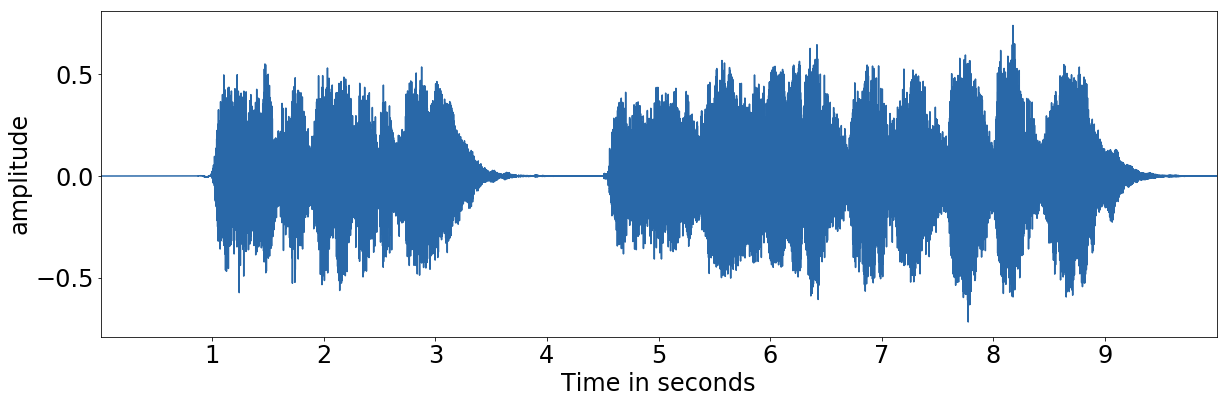

In [46]:
fig = plt.figure()
plt.rcParams['xtick.labelsize']=24
plt.rcParams['ytick.labelsize']=24
fig.set_figwidth(20)
fig.set_figheight(6)
ax1 = fig.add_subplot(111)
ax1.plot(X[0:sec*fs],color=(41/255.,104/255.,168/255.))
ax1.set_xlim([0,sec*fs])
ax1.set_xlabel('sample (44,100Hz)',fontsize=24)
ax1.set_ylabel('amplitude',fontsize=24)
new_tick_locations = np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9])
ax1.set_xticks(new_tick_locations*sec*fs)
ax1.set_xticklabels((new_tick_locations*10).astype(int),fontsize=24)
ax1.set_xlabel(r"Time in seconds",fontsize=24)

plt.savefig("pictures/rec_2494_sounds_10sec.png")

We can play back this time series to hear what it sounds like (15 seconds).

In [56]:
Audio(X[0:sec*fs],rate=fs)

### The Labels
The labels Y are a collection of intervals that indicate the presence of notes in the time series. For convenient access, these notes are stored in an intervaltree. This data structure offers efficient queries for intervals that intersect a particular query point in the time series. For example, we can ask how many notes are being played at time t = 5s in X.

In [68]:
print 'Notes present at sample', str(fs*5),'(5 seconds):', str(len(Y[fs*5]))

Notes present at sample 220500 (5 seconds): 4


Each label consists of an interval (start_time,end_time), instrument and note codes, measure and beat, and the note's metrical duration (i.e. note value). 

In [69]:
(start,end,(instrument,note,measure,beat,note_value)) = sorted(Y[fs*5])[0]
print ' -- An example of a MusicNet label -- '
print ' Start Time:                          ', str(start)
print ' End Time:                            ', str(end)
print ' Instrument (MIDI instrument code):   ', str(instrument)
print ' Note (MIDI note code):               ', str(note)
print ' Measure:                             ', str(measure)
print ' Beat (0 <= beat < 1):                ', str(beat)
print ' Note Value:                          ', str(note_value)

 -- An example of a MusicNet label -- 
 Start Time:                           199134
 End Time:                             223198
 Instrument (MIDI instrument code):    41
 Note (MIDI note code):                55
 Measure:                              3
 Beat (0 <= beat < 1):                 0.0
 Note Value:                           Quarter


### Listen to music & Visualize labels


Extract the corresponding labels and visualize the notes played and colorcode the instruments.

In [70]:
stride = 512                         # 512 samples between windows
wps = fs/float(stride)               # ~86 windows/second
Yvec = np.zeros((int(sec*wps),128))   # 128 distinct note labels
colors = {41 : .33, 42 : .66, 43 : 1}

for ww in range(Yvec.shape[0]): # for every window (512 values from audio-array)
    labels = Y[ww*stride] # extract the notes played
    for label in labels: # for every note played mark it in vector Yvec
        Yvec[ww,label.data[1]] = colors[label.data[0]] # mark which instrument is playing the note if it is played

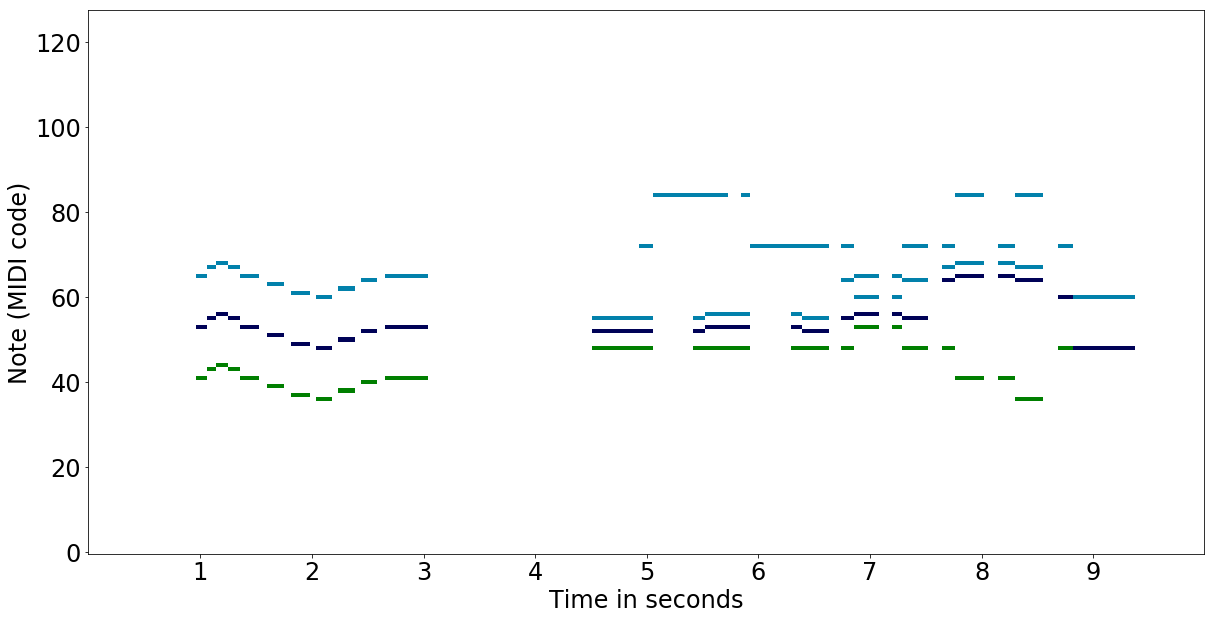

In [71]:
fig = plt.figure(figsize=(20,10))
plt.imshow(Yvec.T,aspect='auto',cmap='ocean_r')
plt.gca().invert_yaxis()
new_tick_locations = np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9])
fig.axes[0].set_xticks(new_tick_locations*sec*wps)
fig.axes[0].set_xticklabels((new_tick_locations*10).astype(int))
fig.axes[0].set_xlabel('Time in seconds',fontsize=24)
fig.axes[0].set_ylabel('Note (MIDI code)',fontsize=24)
plt.savefig("pictures/rec_2494_notes_10sec.png")

Compare the audio (10 seconds) to its labels.

In [72]:
Audio(X[0:sec*fs],rate=fs)

## 2. Demonstration of processes for data augmentation

Always make two small changes to input data by randomly stretching or shrinking our input audio that are not noticable by human hearing, but augment the data set:
1. Pitch-shift in the frequency domain: Randomly  shifting  each data points in a minibatch by an integral number of semitones. This reinforces the architectural structure of the translation-invariant network.
2. Jittering: continuous shift to each data point. This makes the models more robust to tuning variation between recordings --> regularization

In [73]:
window = sec*fs
# pitching: stretching or shrinking our input audio with linear interpolation
pitch_transforms=5 # +/- 5 semitones
jitter=.1

#### 2.1. Pitch-shift
Shift the audio by 5 semitones, which corresponds to a multiplication in the frequency domain by $2^{5/12}$ = 1.33. 
The realization in the time domain corresponds to playing the audio $2^{5/12}$ times faster.

In [74]:
scaling_factor = 2**(float(pitch_transforms)/12)
X_shift=X[0:int(scaling_factor*window)]

Interpolate the array, so that the length of the array stays the same (the sample frequency stays 44.100 Hz)

In [75]:
xp = np.arange(window,dtype=np.float32)
X_shift = np.interp(scaling_factor*xp,np.arange(len(X_shift),dtype=np.float32),X_shift).astype(np.float32)

The music piece sounds now in b flat minor (midi note number 47).

In [76]:
Audio(X_shift[0:sec*fs],rate=fs)

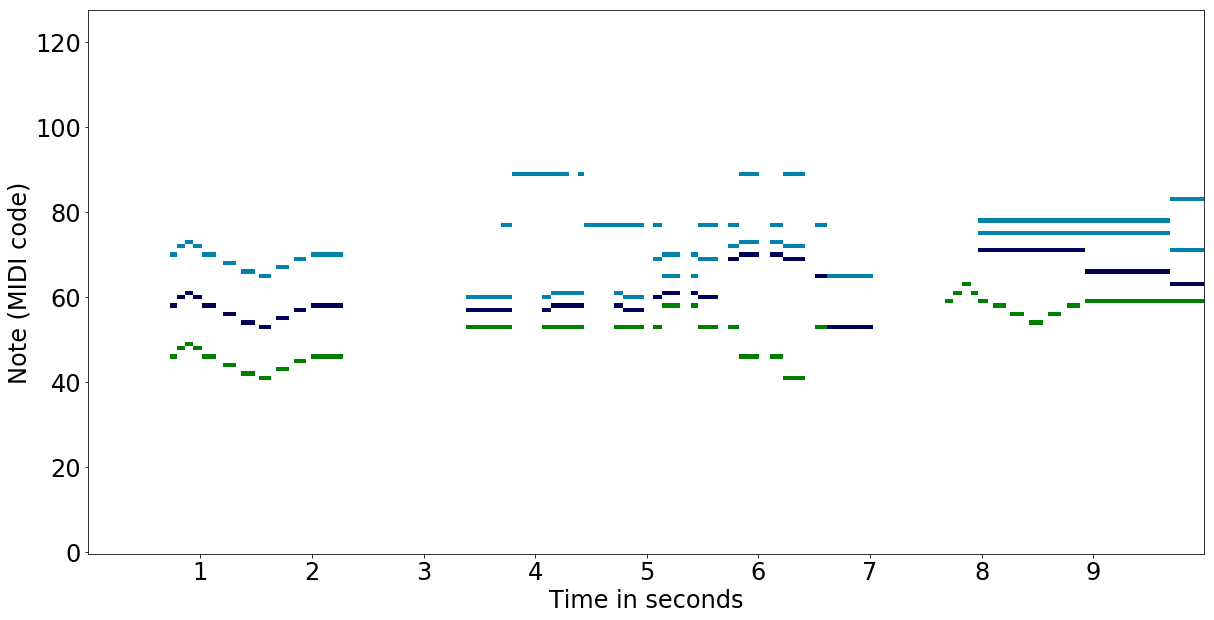

In [77]:
stride = 512                         # 512 samples between windows
wps = fs/float(stride) 
Yvec = np.zeros((int(sec*wps),128))   # 128 distinct note labels
colors = {41 : .33, 42 : .66, 43 : 1}
for ww in range(Yvec.shape[0]): # for every window (512 values from audio-array)
    labels = Y[scaling_factor*ww*stride] # extract the notes played (apply scaling factor)
    for label in labels: # for every note played mark it in vector Yvec
        Yvec[ww,label.data[1]+pitch_transforms] = colors[label.data[0]] # mark which instrument is playing the note if it is played
fig = plt.figure(figsize=(20,10))
plt.imshow(Yvec.T,aspect='auto',cmap='ocean_r')
plt.gca().invert_yaxis()

new_tick_locations = np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9])
fig.axes[0].set_xticks(new_tick_locations*sec*wps)
fig.axes[0].set_xticklabels((new_tick_locations*10).astype(int))
fig.axes[0].set_xlabel('Time in seconds',fontsize=24)
fig.axes[0].set_ylabel('Note (MIDI code)',fontsize=24)
plt.savefig("pictures/rec_2494_pitch_shift_notes_10sec.png")

#### 2.2. Jittering
Apply some jittering.

In [78]:
scaling_factor = 2**(float(jitter)/12)
X_shift=X[0:int(scaling_factor*window)]

In [161]:
xp = np.arange(window,dtype=np.float32)
X_shift = np.interp(scaling_factor*xp,np.arange(len(X_shift),dtype=np.float32),X_shift).astype(np.float32)

In [162]:
Audio(X_shift[0:sec*fs],rate=fs)